In [1]:
# Import necessary libraries
import os
import torch
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

In [2]:
# Defination of the dataset class for the dataset
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        # Initialize the dataset with the root directory and transforms
        self.root = root
        self.transforms = transforms
        # Load all image files and masks, ensuring they are sorted
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # Load an image and its corresponding mask
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        
        # Extract unique object ids (background id is removed)
        obj_ids = torch.unique(mask)[1:]
        num_objs = len(obj_ids)

        # Create binary masks for each object
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # Compute bounding boxes for each object
        boxes = masks_to_boxes(masks)

        # Assign class labels (1 for each object)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # Additional target information
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap the image and target in torchvision tv_tensors
        img = tv_tensors.Image(img)
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)),
            "masks": tv_tensors.Mask(masks),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transformations (if any)
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        # Return the total number of images
        return len(self.imgs)

In [4]:
# Creating a custom Faster R-CNN model with a MobileNetV2 backbone
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Load a MobileNetV2 backbone pre-trained on COCO
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
backbone.out_channels = 1280  # Set the output channels for the backbone

# Define the RPN anchor generator and RoIAlign layer
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# Create a Faster R-CNN model using the custom backbone and RPN generator
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [5]:
# Helper function to create a Mask R-CNN model for instance segmentation
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # Load a pre-trained Mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    
    # Replace the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Replace the mask head
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [6]:
# Downloading utility scripts (engine, utils, coco_utils, coco_eval, transforms)
os.system("powershell -Command \"Invoke-WebRequest -Uri 'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py' -OutFile 'engine.py'\"")
os.system("powershell -Command \"Invoke-WebRequest -Uri 'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py' -OutFile 'utils.py'\"")
os.system("powershell -Command \"Invoke-WebRequest -Uri 'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py' -OutFile 'coco_utils.py'\"")
os.system("powershell -Command \"Invoke-WebRequest -Uri 'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py' -OutFile 'coco_eval.py'\"")
os.system("powershell -Command \"Invoke-WebRequest -Uri 'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py' -OutFile 'transforms.py'\"")


0

In [7]:
# Defining transformations for training and validation
from torchvision.transforms import v2 as T

def get_transform(train):
    # Define transformations for training or testing
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))  # Randomly flip images
    transforms.append(T.ToDtype(torch.float, scale=True))  # Convert images to float
    transforms.append(T.ToPureTensor())  # Convert images to PyTorch tensors
    return T.Compose(transforms)

In [8]:
# Defining the data loader and collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Load the dataset and create the data loader
dataset = PennFudanDataset('C:\\Users\\julha\\Documents\\comp8296project\\PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn  # Use custom collate function
)

In [9]:
# Model training example
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Output losses and detections
print(output)


{'loss_classifier': tensor(0.1902, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0967, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0312, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0074, grad_fn=<DivBackward0>)}


In [10]:
# Model inference example
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Perform predictions
print(predictions[0])

{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [11]:
# Final training loop setup with optimizer and learning rate scheduler
import utils
from engine import train_one_epoch, evaluate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Splitting dataset into train and test subsets
dataset_test = PennFudanDataset('C:\\Users\\julha\\Documents\\comp8296project\\PennFudanPed', get_transform(train=False))
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# Define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Get the model and transfer it to the right device
model = get_model_instance_segmentation(num_classes)
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [12]:
# Model pruning implementation
def prune_model(model, pruning_amount=0.2):
    # Loop through each layer of the model
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d):
            # Prune the weights of the convolutional layer
            torch.nn.utils.prune.l1_unstructured(module, name="weight", amount=pruning_amount)
            # Optionally, remove the pruned weights for efficient inference
            torch.nn.utils.prune.remove(module, 'weight')

# Apply pruning to the model
prune_model(model, pruning_amount=0.2)  # Adjust pruning amount as needed


In [13]:
# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training for a fixed number of epochs
num_epochs = 2
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)  # Adjust print_freq if needed
    lr_scheduler.step()  # Update learning rate
    evaluate(model, data_loader_test, device=device)

    # Optionally, print average loss for the epoch
    # This assumes train_one_epoch returns a dictionary of losses
    # total_loss = train_one_epoch(...) 
    # print(f"Average loss for epoch {epoch + 1}: {total_loss['total_loss']:.4f}")


print("Training complete!")


Epoch 1/2:


C:\Users\julha\Documents\comp8296project\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:01:46  lr: 0.000090  loss: 4.4875 (4.4875)  loss_classifier: 0.7605 (0.7605)  loss_box_reg: 0.2187 (0.2187)  loss_mask: 3.4986 (3.4986)  loss_objectness: 0.0086 (0.0086)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 1.7811  data: 0.0640  max mem: 1998
Epoch: [0]  [10/60]  eta: 0:00:31  lr: 0.000936  loss: 1.7636 (2.2931)  loss_classifier: 0.4673 (0.4778)  loss_box_reg: 0.3130 (0.3188)  loss_mask: 0.8724 (1.4715)  loss_objectness: 0.0129 (0.0193)  loss_rpn_box_reg: 0.0049 (0.0057)  time: 0.6218  data: 0.0303  max mem: 2939
Epoch: [0]  [20/60]  eta: 0:00:21  lr: 0.001783  loss: 0.8287 (1.5299)  loss_classifier: 0.2253 (0.3311)  loss_box_reg: 0.2598 (0.2806)  loss_mask: 0.3727 (0.8903)  loss_objectness: 0.0214 (0.0223)  loss_rpn_box_reg: 0.0049 (0.0056)  time: 0.4776  data: 0.0244  max mem: 2939
Epoch: [0]  [30/60]  eta: 0:00:15  lr: 0.002629  loss: 0.5621 (1.2018)  loss_classifier: 0.0842 (0.2521)  loss_box_reg: 0.1945 (0.2546)  loss_mask: 0.2186 (0.6710)  loss_ob

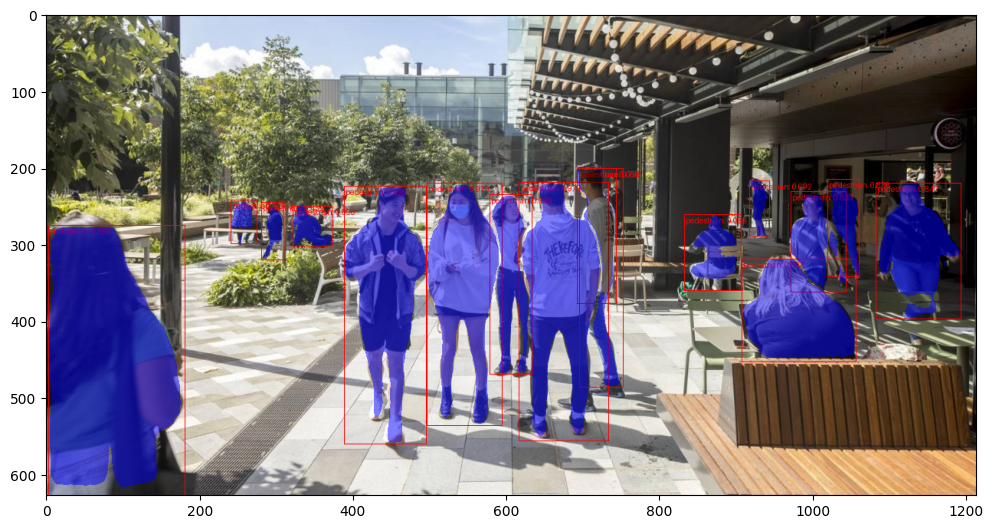

In [14]:
# Testing the model
image = read_image("C:\\Users\\julha\\Documents\\comp8296project\\PennFudanPed\\test.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))